In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import multiprocessing as mlp
import keras
from keras.models import Sequential
from keras.layers import Dense

Read Dataframe that was created before

In [59]:
dataframe = pd.read_csv('four_classes_cleaned.csv', low_memory=False)

In [68]:
dataframe.head()

,SubjectID,Year Term ID_x,Term GPA,Cumul GPA,Term Transfer Hrs,Ps1 Major1 Code,Ps1 Major2 Code,Repeated Flag,Ps1 Acad Standing Desc,Gender,Citizen Country Name,Classification
0,172789163,20062.0,0.00,3.07,0.0,PSY,.,N,ACTIVE,M,USA,N
1,172846340,20102.0,3.30,2.70,26.0,PSC,.,N,PROBATION,F,USA,N
2,172857770,20162.0,0.00,2.20,0.0,ENG,.,N,ACTIVE,M,USA,N
3,172857770,20171.0,0.00,2.20,4.0,ENG,.,N,ACTIVE,M,USA,N
4,175397669,19871.0,2.33,2.33,42.0,PSC,.,N,ACTIVE,M,USA,NG


In [69]:
dataframe.columns

Index(['SubjectID', 'Year Term ID_x', 'Term GPA', 'Cumul GPA',
       'Term Transfer Hrs', 'Ps1 Major1 Code', 'Ps1 Major2 Code',
       'Repeated Flag', 'Ps1 Acad Standing Desc', 'Gender',
       'Citizen Country Name', 'Classification'],
      dtype='object')

In [70]:
len(dataframe)

397031

In [ ]:
dataframe = dataframe.drop(['Ps1 Timestat Code','Ps2 Ofcl Stat Flag','Grade','Ps2 Major1 Code','Unnamed: 0','Cumul Hrs Earned','Year Term ID_y', 'Cumul Hrs GPA','Ps2 Major2 Code', 'Credit Hrs','Reported Grade', 'Dorm Area'], axis =1)

In [72]:
dataframe

,SubjectID,Year Term ID_x,Term GPA,Cumul GPA,Term Transfer Hrs,Ps1 Major1 Code,Ps1 Major2 Code,Repeated Flag,Ps1 Acad Standing Desc,Gender,Citizen Country Name,Classification
0,172789163,20062.0,0.00,3.07,0.0,PSY,.,N,ACTIVE,M,USA,N
1,172846340,20102.0,3.30,2.70,26.0,PSC,.,N,PROBATION,F,USA,N
2,172857770,20162.0,0.00,2.20,0.0,ENG,.,N,ACTIVE,M,USA,N
3,172857770,20171.0,0.00,2.20,4.0,ENG,.,N,ACTIVE,M,USA,N
4,175397669,19871.0,2.33,2.33,42.0,PSC,.,N,ACTIVE,M,USA,NG
...,...,...,...,...,...,...,...,...,...,...,...,...
397026,255137993,20182.0,3.68,3.40,16.0,ME,.,N,ACTIVE,M,HONG KONG,N
397027,255137993,20191.0,4.00,3.48,0.0,ME,.,N,ACTIVE,M,HONG KONG,N
397028,255137993,20192.0,0.00,3.48,0.0,ME,.,N,ACTIVE,M,HONG KONG,N
397029,255461372,20152.0,3.00,3.00,79.0,PHY,.,N,ACTIVE,F,USA,NG


In [63]:
dataframe = dataframe.drop_duplicates()

In [64]:
dataframe =dataframe.reset_index(drop = True)

Remove "fake" zeros from the dataframe (0 term gpa not due to poor academic performance)

In [73]:
from tqdm import tqdm

In [65]:
zeros = dataframe.loc[dataframe['Term GPA']==0].index
len(zeros)

29063

In [66]:
zeros =list(zeros)

In [74]:
real_zeros = []
for i in tqdm(range(0,len(dataframe))):
    if i in zeros:
        if dataframe['Cumul GPA'].iloc[i]>dataframe['Cumul GPA'].iloc[i+1]:
            if dataframe['SubjectID'].iloc[i]==dataframe['SubjectID'].iloc[i+1]:
                real_zeros.append(i)

100%|██████████| 397031/397031 [01:31<00:00, 4352.02it/s]


In [ ]:
real_zero_index = dataframe.iloc[real_zeros]

In [75]:
for i in real_zeros:
    zeros.remove(i)

In [76]:
dataframe = dataframe.drop(zeros)

In [77]:
len(dataframe.loc[dataframe['Term GPA']==0]['SubjectID'].unique())

1500

Group by Students to better access data per student

In [78]:
groups = dataframe.groupby(['SubjectID'], as_index = False)

In [79]:
groups.first()

,SubjectID,Year Term ID_x,Term GPA,Cumul GPA,Term Transfer Hrs,Ps1 Major1 Code,Ps1 Major2 Code,Repeated Flag,Ps1 Acad Standing Desc,Gender,Citizen Country Name,Classification
0,172846340,20102.0,3.30,2.70,26.0,PSC,.,N,PROBATION,F,USA,N
1,175397669,19871.0,2.33,2.33,42.0,PSC,.,N,ACTIVE,M,USA,NG
2,175693463,19972.0,3.10,3.10,17.0,PSY,.,N,ACTIVE,F,USA,N
3,175754600,19901.0,1.70,2.22,0.0,BIG,.,N,ACTIVE,F,USA,NG
4,176716079,19881.0,2.20,1.95,0.0,IDE,.,N,ACTIVE,M,USA,NT
...,...,...,...,...,...,...,...,...,...,...,...,...
20176,252634292,20151.0,2.39,2.39,69.0,OPT,.,N,ACTIVE,M,USA,NG
20177,254575592,20152.0,3.08,3.08,85.0,ECO,.,N,ACTIVE,F,CHINA,N
20178,254613473,20152.0,3.00,3.00,60.0,MST,.,N,ACTIVE,F,CHINA,NT
20179,255137993,20161.0,2.90,2.90,0.0,ME,.,N,ACTIVE,M,HONG KONG,N


Cut out only first four semesters

In [62]:
first_four_semesters = pd.DataFrame(columns=dataframe.columns)

In [82]:
first_four = []
for i in tqdm(dataframe['SubjectID'].unique()):
    x= groups.get_group(i)
    x= x.iloc[0:4, :]
    first_four.append(x)

100%|██████████| 20181/20181 [00:07<00:00, 2564.60it/s]


In [83]:
first_four_semesters= pd.concat(first_four)

In [84]:
first_four_semesters.head()

,SubjectID,Year Term ID_x,Term GPA,Cumul GPA,Term Transfer Hrs,Ps1 Major1 Code,Ps1 Major2 Code,Repeated Flag,Ps1 Acad Standing Desc,Gender,Citizen Country Name,Classification
1,172846340,20102.0,3.30,2.70,26.0,PSC,.,N,PROBATION,F,USA,N
4,175397669,19871.0,2.33,2.33,42.0,PSC,.,N,ACTIVE,M,USA,NG
5,175397669,19871.0,2.33,2.33,42.0,ECO,.,N,ACTIVE,M,USA,NG
6,175397669,19871.0,2.33,2.33,42.0,ECO,.,N,PROBATION,M,USA,NG
7,175397669,19871.0,2.33,2.33,42.0,UNC,.,N,PROBATION,M,USA,NG


In [85]:
ffs = first_four_semesters.copy(deep= True)

In [86]:
ffs['SubjectID'].value_counts()

240670709    4
188907974    4
233064863    4
192395681    4
201566627    4
            ..
194868080    1
194634926    1
194484734    1
239174936    1
192712202    1
Name: SubjectID, Length: 20181, dtype: int64

Changing Columns into more abstract information/ reduces memory

In [87]:
doubles = pd.read_csv('double.csv', names =['0','ids'])
double_list = doubles['ids']
ffs['double major']=0
ffs.loc[ffs['SubjectID'].isin(double_list), 'double major']=1

In [88]:
ffs = ffs.drop(['Ps1 Major2 Code'], axis =1)

In [89]:
ffs

,SubjectID,Year Term ID_x,Term GPA,Cumul GPA,Term Transfer Hrs,Ps1 Major1 Code,Repeated Flag,Ps1 Acad Standing Desc,Gender,Citizen Country Name,Classification,double major
1,172846340,20102.0,3.30,2.70,26.0,PSC,N,PROBATION,F,USA,N,1
4,175397669,19871.0,2.33,2.33,42.0,PSC,N,ACTIVE,M,USA,NG,1
5,175397669,19871.0,2.33,2.33,42.0,ECO,N,ACTIVE,M,USA,NG,1
6,175397669,19871.0,2.33,2.33,42.0,ECO,N,PROBATION,M,USA,NG,1
7,175397669,19871.0,2.33,2.33,42.0,UNC,N,PROBATION,M,USA,NG,1
...,...,...,...,...,...,...,...,...,...,...,...,...
397022,255137993,20162.0,3.35,3.13,0.0,ME,N,ACTIVE,M,HONG KONG,N,1
397023,255137993,20171.0,3.18,3.14,0.0,ME,N,ACTIVE,M,HONG KONG,N,1
397024,255137993,20172.0,4.00,3.33,0.0,ME,N,ACTIVE,M,HONG KONG,N,1
397029,255461372,20152.0,3.00,3.00,79.0,PHY,N,ACTIVE,F,USA,NG,1


In [90]:
def probation_counts(model):
    for i in tqdm(model['SubjectID'].unique()):
        model.loc[model['SubjectID']==i,'Probation term numbers']=model.loc[model['SubjectID']==i]['Ps1 Acad Standing Desc'].value_counts().to_dict().get('PROBATION')
    return model
def probation(df): 
    for i in df['SubjectID'].unique():
        df.loc[df['SubjectID']==i,'Probation term normalized']= df['Probation term numbers']/((df['SubjectID']==i).sum())
    return df

In [91]:
import multiprocessing

num_processes = multiprocessing.cpu_count()
chunk_size = int(ffs.shape[0]/num_processes)
chunks = [ffs.loc[ffs.index[i:i + chunk_size]] for i in range(0, ffs.shape[0], chunk_size)]

In [ ]:
pool = multiprocessing.Pool(processes=num_processes)
result = pool.map(probation_counts, chunks)
results = pd.concat(result)

In [93]:
ffs = results.copy(deep = True)

In [94]:
num_processes = multiprocessing.cpu_count()
chunk_size = int(ffs.shape[0]/num_processes)
chunks = [ffs.loc[ffs.index[i:i + chunk_size]] for i in range(0, ffs.shape[0], chunk_size)]


In [ ]:
pool = multiprocessing.Pool(processes=num_processes)
result = pool.map(probation, chunks)
results = pd.concat(result)

In [96]:
ffs = results.copy(deep =True)

In [97]:
ffs = ffs.drop(['Probation term numbers'], axis =1)

In [98]:
ffs['Probation term normalized']=ffs['Probation term normalized'].fillna(0)

In [99]:
ffs

,SubjectID,Year Term ID_x,Term GPA,Cumul GPA,Term Transfer Hrs,Ps1 Major1 Code,Repeated Flag,Ps1 Acad Standing Desc,Gender,Citizen Country Name,Classification,double major,Probation term normalized
1,172846340,20102.0,3.30,2.70,26.0,PSC,N,PROBATION,F,USA,N,1,1.0
4,175397669,19871.0,2.33,2.33,42.0,PSC,N,ACTIVE,M,USA,NG,1,0.5
5,175397669,19871.0,2.33,2.33,42.0,ECO,N,ACTIVE,M,USA,NG,1,0.5
6,175397669,19871.0,2.33,2.33,42.0,ECO,N,PROBATION,M,USA,NG,1,0.5
7,175397669,19871.0,2.33,2.33,42.0,UNC,N,PROBATION,M,USA,NG,1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
397022,255137993,20162.0,3.35,3.13,0.0,ME,N,ACTIVE,M,HONG KONG,N,1,0.0
397023,255137993,20171.0,3.18,3.14,0.0,ME,N,ACTIVE,M,HONG KONG,N,1,0.0
397024,255137993,20172.0,4.00,3.33,0.0,ME,N,ACTIVE,M,HONG KONG,N,1,0.0
397029,255461372,20152.0,3.00,3.00,79.0,PHY,N,ACTIVE,F,USA,NG,1,0.0


Encode data for learning model

In [100]:
ffs.loc[ffs['Citizen Country Name']!='USA', 'Citizen Country Name']=0
ffs.loc[ffs['Citizen Country Name']=='USA', 'Citizen Country Name']=1

In [101]:
ffs.loc[ffs['Classification']=='N', 'Classification']=3
ffs.loc[ffs['Classification']=='NT', 'Classification']=2
ffs.loc[ffs['Classification']=='TP', 'Classification']=1
ffs.loc[ffs['Classification']=='NG', 'Classification']=0

Model with Term GPA. 

In [194]:
X = ffs.drop(['Classification'], axis =1)
y = ffs['Classification']

In [195]:
X['Citizen Country Name'].value_counts()

1    68473
0     9620
Name: Citizen Country Name, dtype: int64

In [196]:
X = X.drop(['Year Term ID_x', 'Ps1 Acad Standing Desc'], axis =1)

In [197]:
X.loc[ffs['Term Transfer Hrs']!=0, 'Term Transfer Hrs']=1
X.loc[ffs['Term Transfer Hrs']==0, 'Term Transfer Hrs']=0

In [198]:
X = X.rename(columns={"Ps1 Major1 Code": "Major"})

In [199]:
X

,SubjectID,Term GPA,Cumul GPA,Term Transfer Hrs,Major,Repeated Flag,Gender,Citizen Country Name,double major,Probation term normalized
1,172846340,3.30,2.70,1.0,PSC,N,F,1,1,1.0
4,175397669,2.33,2.33,1.0,PSC,N,M,1,1,0.5
5,175397669,2.33,2.33,1.0,ECO,N,M,1,1,0.5
6,175397669,2.33,2.33,1.0,ECO,N,M,1,1,0.5
7,175397669,2.33,2.33,1.0,UNC,N,M,1,1,0.5
...,...,...,...,...,...,...,...,...,...,...
397022,255137993,3.35,3.13,0.0,ME,N,M,0,1,0.0
397023,255137993,3.18,3.14,0.0,ME,N,M,0,1,0.0
397024,255137993,4.00,3.33,0.0,ME,N,M,0,1,0.0
397029,255461372,3.00,3.00,1.0,PHY,N,F,1,1,0.0


In [200]:
X = pd.get_dummies(data = X, columns= ['Major', 'Repeated Flag', 'Gender'],  dummy_na=False)

In [201]:
for i in X.columns:
    X[i]= X[i]/X[i].max()

In [202]:
X.isnull().sum()

SubjectID               0
Term GPA                0
Cumul GPA               0
Term Transfer Hrs       0
Citizen Country Name    0
                       ..
Major_WS                0
Repeated Flag_N         0
Repeated Flag_Y         0
Gender_F                0
Gender_M                0
Length: 108, dtype: int64

In [203]:
y= pd.get_dummies(data = y, columns = ['Classification'])

In [204]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [205]:
classifier = Sequential()
classifier.add(Dense(activation= 'relu', input_dim = 108, units = 64, init = 'uniform'))
classifier.add(Dense(activation= 'relu', units = 64, init = 'uniform'))
classifier.add(Dense(activation= 'relu', units = 32, init = 'uniform'))
classifier.add(Dense(activation= 'relu', units = 16, init = 'uniform'))
classifier.add(Dense(activation= 'softmax', units = 4, init = 'uniform'))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=108, units=64, kernel_initializer="uniform")`
  
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-pac

In [206]:
history =classifier.fit(X, y, epochs = 400, batch_size = 2048)
print(history.history.keys())

Epoch 1/400
78093/78093 [==============================] - 2s 28us/step - loss: 1.3254 - accuracy: 0.5656
Epoch 2/400
78093/78093 [==============================] - 2s 26us/step - loss: 0.9841 - accuracy: 0.5763
Epoch 3/400
78093/78093 [==============================] - 2s 25us/step - loss: 0.9518 - accuracy: 0.5763
Epoch 4/400
78093/78093 [==============================] - 2s 26us/step - loss: 0.9348 - accuracy: 0.5764
Epoch 5/400
78093/78093 [==============================] - 2s 26us/step - loss: 0.9197 - accuracy: 0.5826
Epoch 6/400
78093/78093 [==============================] - 2s 26us/step - loss: 0.9133 - accuracy: 0.5892
Epoch 7/400
78093/78093 [==============================] - 2s 26us/step - loss: 0.9104 - accuracy: 0.5952
Epoch 8/400
78093/78093 [==============================] - 2s 26us/step - loss: 0.9070 - accuracy: 0.6008
Epoch 9/400
78093/78093 [==============================] - 2s 26us/step - loss: 0.9051 - accuracy: 0.6027
Epoch 10/400
78093/78093 [====================

<function matplotlib.pyplot.show(*args, **kw)>

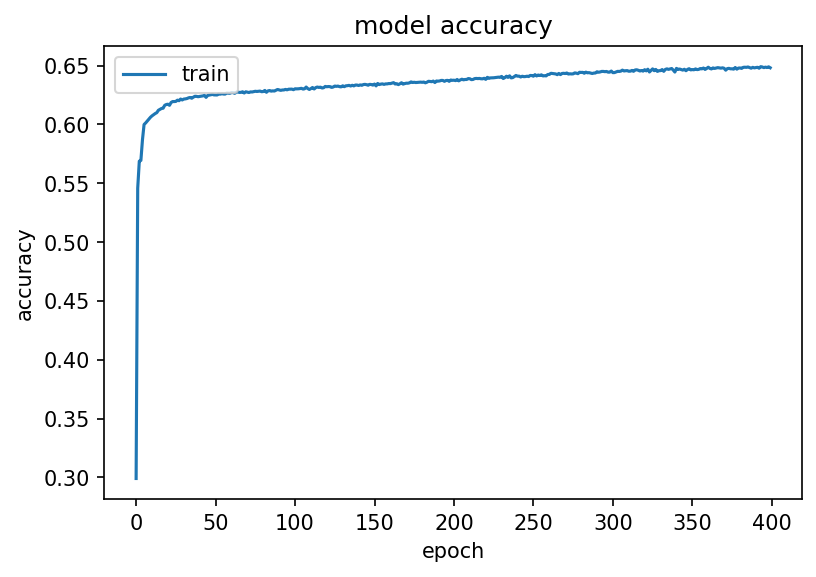

In [255]:
plt.figure(dpi=150)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')
plt.show

Model with mined data/ does not include term to term data

In [372]:
temp = pd.read_csv('model final test.csv')

Simplication process

In [110]:
to_one = []
for i in tqdm(ffs['SubjectID'].unique()):
    x = groups.get_group(i)
    x['Min GPA']= x['Term GPA'].min()
    x['Number of Majors'] = x['Ps1 Major1 Code'].nunique()
    x['Hardest Semester']= np.argmin(x['Term GPA'])
    to_one.append(x)

  0%|          | 0/20181 [00:00<?, ?it/s]/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [123]:
final = pd.concat(to_one)

In [113]:
final = final.drop_duplicates()

In [132]:
final

,SubjectID,Cumul GPA,Term Transfer Hrs,Major,Gender,Citizen Country Name,Classification,Min GPA,Number of Majors,Hardest Semester
1,172846340,2.70,1.0,PSC,F,1,3,3.30,1,0
4,175397669,2.33,1.0,PSC,M,1,0,1.13,3,10
5,175397669,2.33,1.0,ECO,M,1,0,1.13,3,10
7,175397669,2.33,1.0,UNC,M,1,0,1.13,3,10
9,175397669,2.00,0.0,PSC,M,1,0,1.13,3,10
...,...,...,...,...,...,...,...,...,...,...
397024,255137993,3.33,0.0,ME,M,0,3,2.90,1,0
397026,255137993,3.40,1.0,ME,M,0,3,2.90,1,0
397027,255137993,3.48,0.0,ME,M,0,3,2.90,1,0
397029,255461372,3.00,1.0,PHY,F,1,0,0.70,1,1


Same labeling process as the previous model

In [130]:
final.loc[final['Classification']=='N', 'Classification']=3
final.loc[final['Classification']=='NT', 'Classification']=2
final.loc[final['Classification']=='TP', 'Classification']=1
final.loc[final['Classification']=='NG', 'Classification']=0
final.loc[final['Citizen Country Name']!='USA', 'Citizen Country Name']=0
final.loc[final['Citizen Country Name']=='USA', 'Citizen Country Name']=1
final.loc[final['Term Transfer Hrs']!=0, 'Term Transfer Hrs']=1
final.loc[final['Term Transfer Hrs']==0, 'Term Transfer Hrs']=0
final = final.drop(['Repeated Flag','Year Term ID_x', 'Ps1 Acad Standing Desc', 'Ps1 Major2 Code','Term GPA'], axis =1)
final= final.rename(columns={"Ps1 Major1 Code": "Major"})

In [131]:
final =final.drop_duplicates()

Only keeping the final GPA

In [134]:
num_processes = multiprocessing.cpu_count()
chunk_size = int(final.shape[0]/num_processes)
chunks = [final.loc[final.index[i:i + chunk_size]] for i in range(0, final.shape[0], chunk_size)]
pool = multiprocessing.Pool(processes=num_processes)
result = pool.map(last_gpa, chunks)
results = pd.concat(result)

In [133]:
def last_gpa(df):
    for i in df['SubjectID'].unique():
        df.loc[df['SubjectID']==i, 'Cumul GPA']= df.loc[df['SubjectID']==i]['Cumul GPA'].iloc[-1]
    return df

In [135]:
final = results.copy(deep=True)

In [141]:
final = final.drop_duplicates()

In [139]:
final = final.drop(['Term Transfer Hrs', 'Hardest Semester'], axis =1)

In [142]:
final

,SubjectID,Cumul GPA,Major,Gender,Citizen Country Name,Classification,Min GPA,Number of Majors
1,172846340,2.70,PSC,F,1,3,3.30,1
4,175397669,2.07,PSC,M,1,0,1.13,3
5,175397669,2.07,ECO,M,1,0,1.13,3
7,175397669,2.07,UNC,M,1,0,1.13,3
59,175693463,3.02,PSY,F,1,3,2.65,2
...,...,...,...,...,...,...,...,...
396973,254575592,2.79,CSC,F,0,3,1.35,3
397012,254613473,3.08,MST,F,0,2,2.00,1
397021,255137993,3.14,ME,M,0,3,2.90,1
397024,255137993,3.48,ME,M,0,3,2.90,1


Model creation 

In [ ]:
X_one = final.drop(['Classification'], axis =1)
y_one = final['Classification']

In [144]:
X_one = pd.get_dummies(data = X_one, columns= ['Major', 'Gender'],  dummy_na=False)

In [145]:
y_one = pd.get_dummies(data = y_one, columns = ['Classification'])

In [146]:
for i in X_one.columns:
    X_one[i]= X_one[i]/X_one[i].max()

In [147]:
len(y_one)

34059

In [148]:
X_one['Min GPA'].value_counts()

0.0000    2729
0.7500     778
0.5000     563
0.8325     507
0.7950     450
          ... 
0.0950       1
0.1400       1
0.2275       1
0.1025       1
0.0200       1
Name: Min GPA, Length: 367, dtype: int64

Train Test Split and learning

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X_one,y_one,test_size = .10)

In [152]:
classifier = Sequential()
classifier.add(Dense(activation= 'relu', input_dim = 106, units = 54, init = 'uniform'))
classifier.add(Dense(activation= 'relu', units = 40, init = 'uniform'))
classifier.add(Dense(activation= 'relu', units = 32, init = 'uniform'))
classifier.add(Dense(activation= 'relu', units = 16, init = 'uniform'))
classifier.add(Dense(activation= 'softmax', units = 4, init = 'uniform'))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=106, units=128, kernel_initializer="uniform")`
  
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-pa

In [173]:
def model_fit():
    classifier = Sequential()
    classifier.add(Dense(activation= 'relu', input_dim = 106, units = 54, init = 'uniform'))
    classifier.add(Dense(activation= 'relu', units = 40, init = 'uniform'))
    classifier.add(Dense(activation= 'relu', units = 32, init = 'uniform'))
    classifier.add(Dense(activation= 'relu', units = 16, init = 'uniform'))
    classifier.add(Dense(activation= 'softmax', units = 4, init = 'uniform'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
    return classifier

K fold validation

In [174]:
from sklearn.model_selection import KFold

n_split =5

for train_index,test_index in KFold(n_split).split(X_one):
    x_train,x_test=X_one.iloc[train_index],X_one.iloc[test_index]
    y_train,y_test=y_one.iloc[train_index],y_one.iloc[test_index]
    split_model=model_fit()
    split_model.fit(x_train, y_train,epochs=300,batch_size = 3036)
    print('Model evaluation ',split_model.evaluate(x_test,y_test))

/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=106, units=54, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=40, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="uniform")`
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  
/home/jaeheuk/anaconda3/lib/python3.7/site-pac

Epoch 1/300
27247/27247 [==============================] - 1s 26us/step - loss: 1.3829 - accuracy: 0.5336
Epoch 2/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.3742 - accuracy: 0.5585
Epoch 3/300
27247/27247 [==============================] - 1s 25us/step - loss: 1.3612 - accuracy: 0.5585
Epoch 4/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.3305 - accuracy: 0.5585
Epoch 5/300
27247/27247 [==============================] - 1s 24us/step - loss: 1.2444 - accuracy: 0.5585
Epoch 6/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.0793 - accuracy: 0.5585
Epoch 7/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.0038 - accuracy: 0.5585
Epoch 8/300
27247/27247 [==============================] - 1s 23us/step - loss: 0.9904 - accuracy: 0.5585
Epoch 9/300
27247/27247 [==============================] - 1s 23us/step - loss: 0.9787 - accuracy: 0.5585
Epoch 10/300
27247/27247 [====================

/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=106, units=54, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=40, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="uniform")`
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  
/home/jaeheuk/anaconda3/lib/python3.7/site-pac

Epoch 1/300
27247/27247 [==============================] - 1s 26us/step - loss: 1.3828 - accuracy: 0.5157
Epoch 2/300
27247/27247 [==============================] - 1s 22us/step - loss: 1.3737 - accuracy: 0.5555
Epoch 3/300
27247/27247 [==============================] - 1s 22us/step - loss: 1.3603 - accuracy: 0.5555
Epoch 4/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.3315 - accuracy: 0.5555
Epoch 5/300
27247/27247 [==============================] - 1s 22us/step - loss: 1.2531 - accuracy: 0.5555
Epoch 6/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.0895 - accuracy: 0.5555
Epoch 7/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.0061 - accuracy: 0.5555
Epoch 8/300
27247/27247 [==============================] - 1s 23us/step - loss: 0.9978 - accuracy: 0.5555
Epoch 9/300
27247/27247 [==============================] - 1s 23us/step - loss: 0.9849 - accuracy: 0.5555
Epoch 10/300
27247/27247 [====================

/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=106, units=54, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=40, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="uniform")`
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  
/home/jaeheuk/anaconda3/lib/python3.7/site-pac

Epoch 1/300
27247/27247 [==============================] - 1s 28us/step - loss: 1.3825 - accuracy: 0.5401
Epoch 2/300
27247/27247 [==============================] - 1s 24us/step - loss: 1.3718 - accuracy: 0.5493
Epoch 3/300
27247/27247 [==============================] - 1s 24us/step - loss: 1.3526 - accuracy: 0.5493
Epoch 4/300
27247/27247 [==============================] - 1s 24us/step - loss: 1.3042 - accuracy: 0.5493
Epoch 5/300
27247/27247 [==============================] - 1s 25us/step - loss: 1.1851 - accuracy: 0.5493
Epoch 6/300
27247/27247 [==============================] - 1s 25us/step - loss: 1.0391 - accuracy: 0.5493
Epoch 7/300
27247/27247 [==============================] - 1s 24us/step - loss: 1.0228 - accuracy: 0.5493
Epoch 8/300
27247/27247 [==============================] - 1s 24us/step - loss: 0.9986 - accuracy: 0.5493
Epoch 9/300
27247/27247 [==============================] - 1s 25us/step - loss: 0.9913 - accuracy: 0.5493
Epoch 10/300
27247/27247 [====================

/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=106, units=54, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=40, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="uniform")`
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  
/home/jaeheuk/anaconda3/lib/python3.7/site-pac

Epoch 1/300
27247/27247 [==============================] - 1s 27us/step - loss: 1.3828 - accuracy: 0.4959
Epoch 2/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.3737 - accuracy: 0.5456
Epoch 3/300
27247/27247 [==============================] - 1s 22us/step - loss: 1.3593 - accuracy: 0.5456
Epoch 4/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.3250 - accuracy: 0.5456
Epoch 5/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.2326 - accuracy: 0.5456
Epoch 6/300
27247/27247 [==============================] - 1s 22us/step - loss: 1.0750 - accuracy: 0.5456
Epoch 7/300
27247/27247 [==============================] - 1s 23us/step - loss: 1.0251 - accuracy: 0.5456
Epoch 8/300
27247/27247 [==============================] - 1s 24us/step - loss: 1.0063 - accuracy: 0.5456
Epoch 9/300
27247/27247 [==============================] - 1s 23us/step - loss: 0.9986 - accuracy: 0.5456
Epoch 10/300
27247/27247 [====================

/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=106, units=54, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=40, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="uniform")`
  """
/home/jaeheuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  
/home/jaeheuk/anaconda3/lib/python3.7/site-pac

Epoch 1/300
27248/27248 [==============================] - 1s 27us/step - loss: 1.3830 - accuracy: 0.3158
Epoch 2/300
27248/27248 [==============================] - 1s 22us/step - loss: 1.3750 - accuracy: 0.3365
Epoch 3/300
27248/27248 [==============================] - 1s 23us/step - loss: 1.3635 - accuracy: 0.3365
Epoch 4/300
27248/27248 [==============================] - 1s 23us/step - loss: 1.3380 - accuracy: 0.3365
Epoch 5/300
27248/27248 [==============================] - 1s 24us/step - loss: 1.2656 - accuracy: 0.3365
Epoch 6/300
27248/27248 [==============================] - 1s 23us/step - loss: 1.1167 - accuracy: 0.4103
Epoch 7/300
27248/27248 [==============================] - 1s 23us/step - loss: 1.0155 - accuracy: 0.5497
Epoch 8/300
27248/27248 [==============================] - 1s 23us/step - loss: 1.0070 - accuracy: 0.5497
Epoch 9/300
27248/27248 [==============================] - 1s 23us/step - loss: 0.9894 - accuracy: 0.5497
Epoch 10/300
27248/27248 [====================

In [153]:
history =classifier.fit(X_train, y_train, epochs = 300, batch_size = 2048)


Epoch 1/300
30653/30653 [==============================] - 1s 36us/step - loss: 1.3793 - accuracy: 0.5222
Epoch 2/300
30653/30653 [==============================] - 1s 23us/step - loss: 1.3487 - accuracy: 0.5519
Epoch 3/300
30653/30653 [==============================] - 1s 23us/step - loss: 1.1809 - accuracy: 0.5519
Epoch 4/300
30653/30653 [==============================] - 1s 24us/step - loss: 1.0134 - accuracy: 0.5519
Epoch 5/300
30653/30653 [==============================] - 1s 23us/step - loss: 0.9902 - accuracy: 0.5519
Epoch 6/300
30653/30653 [==============================] - 1s 23us/step - loss: 0.9799 - accuracy: 0.5519
Epoch 7/300
30653/30653 [==============================] - 1s 23us/step - loss: 0.9739 - accuracy: 0.5519
Epoch 8/300
30653/30653 [==============================] - 1s 24us/step - loss: 0.9695 - accuracy: 0.5519
Epoch 9/300
30653/30653 [==============================] - 1s 24us/step - loss: 0.9655 - accuracy: 0.5519
Epoch 10/300
30653/30653 [===================

NameError: name 'plt' is not defined

In [154]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

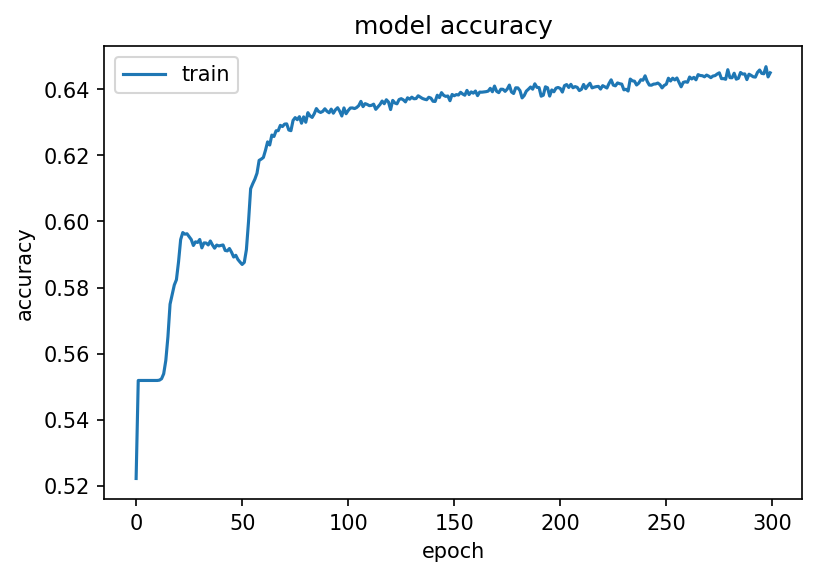

In [156]:
plt.figure(dpi = 150)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')
plt.show

In [178]:
from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as skm
predictions = classifier.predict(x_test)
y_pred = predictions>.5
y_pred = y_pred.astype(int)
multilabel_confusion_matrix(y_pred, y_test)

array([[[6191,  337],
        [  26,  257]],

       [[6659,  149],
        [   0,    3]],

       [[4085, 1668],
        [ 475,  583]],

       [[1397,  626],
        [1600, 3188]]])

In [179]:
y_true = np.array(y_test)
y_pred = np.array(y_pred)

In [180]:
matrix = skm.confusion_matrix(y_true.argmax(axis =1), y_pred.argmax(axis=1), labels = [0,1,2,3])

In [181]:
print(matrix)

[[ 361    0   69  164]
 [  48    3   67   34]
 [ 266    0  583 1402]
 [ 287    0  339 3188]]


In [182]:
print(skm.classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.38      0.61      0.46       594
           1       1.00      0.02      0.04       152
           2       0.55      0.26      0.35      2251
           3       0.67      0.84      0.74      3814

    accuracy                           0.61      6811
   macro avg       0.65      0.43      0.40      6811
weighted avg       0.61      0.61      0.57      6811



In [183]:
pd.DataFrame(matrix, index=['Non graduates', '+12', '9~12', 'Normal'], columns=['Non graduates', '+12', '9~12', 'Normal'])

,Non graduates,+12,9~12,Normal
Non graduates,361,0,69,164
+12,48,3,67,34
9~12,266,0,583,1402
Normal,287,0,339,3188


Turns out to be very inaccurate in deciding whether the student is going to graduate or not. It seems like the graduation rate is more decisive based on the performance in Junior/ Senior year. 